<CENTER><img src="../../images/ATLASOD.gif" style="width:50%"></CENTER>

# <CENTER><h1>Reconstruction of invariant mass of Z boson decaying into two leptons </h1></CENTER>

## Simple notebook example
<p> In this notebook you can find an easy set of commands that show the basic computing techniques commonly used in high energy  physics (HEP) analysis. It also shows how to create a histogram, fill it, draw it and uses a fit function on it. At the end you get a plot with the invariant mass of the two leptons system, which represents the mass of Z boson.</p>

<p> The Analysis is implemented by using some useful tools, such as pandas (to storage dataframes), numpy (the numerical library of python), uproot3 (to read root files), matplotlib (to plot our graphics) and scipy libary (which allows us to fit our histogram using a gaussian function).

First at all, we should verify that we have installed all need tools to perform our analysis. If we haven't, we can run the next code line:

In [1]:
import sys
#!{sys.executable} -m pip install --upgrade --user pip # update the pip package installer
#!{sys.executable} -m pip install -U numpy pandas uproot3 matplotlib --user # install required packages

Now, we can import the tools that we are going to use (pandas, numpy, matplotlib, etc):

In [2]:
import pandas as pd # to store data as dataframes
import numpy as np # for numerical calculations such as histogramming
import uproot # to read .root files as dataframes
import matplotlib.pyplot as plt # for plotting
import awkward as ak
from scipy.optimize import curve_fit
import time

The root file which contains the events information is stored in [2J2LMET30/Data folder](https://atlas-opendata.web.cern.ch/13TeV/2J2LMET30/Data/). So we are going to define the ```path_folder``` variable which contains the url where the files are uploaded:

In [3]:
path_folder = 'https://atlas-opendata.web.cern.ch/13TeV/2J2LMET30/Data/'

In [4]:
# Here you can add or remove the data samples for the analysis
#data_list = ['data15_periodD']
data_list = ['data15_periodD', 'data15_periodE', 'data15_periodF', 'data15_periodG', 'data15_periodH', 
             'data15_periodJ', 'data16_periodA', 'data16_periodB', 'data16_periodC', 'data16_periodD', 
             'data16_periodE', 'data16_periodF', 'data16_periodG', 'data16_PeriodI', 'data16_periodK',
             'data16_periodL'] # Whole list of data samples available

Lets print the url and the number of events for all the samples given in the ```data_list``` you defined above: 

In [5]:
for sample in data_list:
    path_file = path_folder+sample+'.root'
    print(path_file)
    tree = uproot.open(path_file)["analysis"] # open the tree called analysis
    numevents = tree.num_entries # number of events
    print("Number of events in sample "+sample+": ", numevents)

https://atlas-opendata.web.cern.ch/13TeV/2J2LMET30/Data/data15_periodD.root
Number of events in sample data15_periodD:  5482
https://atlas-opendata.web.cern.ch/13TeV/2J2LMET30/Data/data15_periodE.root
Number of events in sample data15_periodE:  44036
https://atlas-opendata.web.cern.ch/13TeV/2J2LMET30/Data/data15_periodF.root
Number of events in sample data15_periodF:  30743
https://atlas-opendata.web.cern.ch/13TeV/2J2LMET30/Data/data15_periodG.root
Number of events in sample data15_periodG:  71420
https://atlas-opendata.web.cern.ch/13TeV/2J2LMET30/Data/data15_periodH.root
Number of events in sample data15_periodH:  28217
https://atlas-opendata.web.cern.ch/13TeV/2J2LMET30/Data/data15_periodJ.root
Number of events in sample data15_periodJ:  142381
https://atlas-opendata.web.cern.ch/13TeV/2J2LMET30/Data/data16_periodA.root
Number of events in sample data16_periodA:  53803
https://atlas-opendata.web.cern.ch/13TeV/2J2LMET30/Data/data16_periodB.root
Number of events in sample data16_periodB:

The ```fraction``` variable is defined if we don't want to run our analysis over the whole events in the root files, but if it is not the case, you can leave it as iqual to 1.0

In [6]:
fraction = 0.5

Next, we define a function that computes the invariant mass of the two lepton system. This function requires the $pT$, $\eta$, $\phi$ and $E$ of each lepton to return the invariant mass.

In [7]:
# Calculate invariant mass of the 4-lepton state
# [:, i] selects the i-th lepton in each event
def calc_mass(lep_pt, lep_eta, lep_phi, lep_e):
    
    # sumE = sum of energy
    sumE = lep_e[:, 0]+lep_e[:, 1]
    
    px_0 = lep_pt[:, 0]*np.cos(lep_phi[:, 0]) # x-momentum of 0th lepton
    px_1 = lep_pt[:, 1]*np.cos(lep_phi[:, 1]) # x-momentum of 1st lepton
    py_0 = lep_pt[:, 0]*np.sin(lep_phi[:, 0]) # y-momentum of 0th lepton
    py_1 = lep_pt[:, 1]*np.sin(lep_phi[:, 1]) # y-momentum of 1st lepton
    pz_0 = lep_pt[:, 0]*np.sinh(lep_eta[:, 0]) # z-momentum of 0th lepton
    pz_1 = lep_pt[:, 1]*np.sinh(lep_eta[:, 1]) # z-momentum of 1st lepton
    
    # sumpx = sum of x-momenta
    sumpx = px_0 + px_1
    
    # sumpy = sum of y-momenta
    sumpy = py_0 + py_1
    
    # sumpz = sum of z-momenta
    sumpz = pz_0 + pz_1
    
    # sump = magnitude of total momentum vector. Remember it's a vector!
    sump = ((sumpx)**2 + (sumpy)**2 + (sumpz)**2)**(1/2)
    
    # Mll = invariant mass from M^2 = E^2 - p^2
    Mll = ((sumE)**2 - (sump)**2)**(1/2)
    
    return Mll # divide by 1000 to go from MeV to GeV

When we want to fit some data to a determined function, we can previously define it and then use it at the end of the analysis. For this reason, we define the gaussian function with the parameters that we are going to fit (amplitude, mu and the standard deviation):  

In [8]:
def gauss(x, amp, mu, sigma):
    return amp*np.exp(-((x-mu)**2)/(2*sigma**2))

Now, we are ready to implement some basic cuts in our data. Here, we can find three main cuts, which are:
1. ***Opposite_charge_cut***: Remove all events in which the two leptons have opposite charge
2. ***lep_type_cut***: Remove all events in which the two leptons don't belong to the same family.

In [9]:
# Cut lepton type (electron type is 11,  muon type is 13)
def cut_lep_type(lep_type):
    sum_lep_type = lep_type[:, 0] + lep_type[:, 1]
    lep_type_cut_bool = (sum_lep_type != 22) & (sum_lep_type != 26)
    return lep_type_cut_bool # True means we should remove this entry (lepton type does not match)

# Cut lepton charge
def cut_lep_charge(lep_charge):
    # first lepton in each event is [:, 0], 2nd lepton is [:, 1] etc
    sum_lep_charge = lep_charge[:, 0] + lep_charge[:, 1] != 0
    return sum_lep_charge # True means we should remove this entry (sum of lepton charges is not equal to 0)

The next code line is going to implement the cuts over the data and save the selected events in awkward vector ```sample_data``` using the library **awkward**. 

In [10]:
start = time.time() # time at start of whole processing

sample_data = []
variables = ['lep_charge', 'lep_type', 'lep_pt','lep_eta','lep_phi','lep_e']

total_initial_events = 0
total_final_events = 0

for sample in data_list:
    path_file = path_folder+sample+'.root'
    tree = uproot.open(path_file)["analysis"] # open the tree called analysis
    numevents = tree.num_entries # number of events
    print("Processing sample "+sample+" with a total number of events: ", numevents)
    entrystop = int(numevents * fraction)
    
    # Perform the cuts for each data entry in the tree
    for data in tree.iterate(variables, entry_stop=entrystop, step_size=int(entrystop*0.35), library="ak"): # the data will be in the form of an awkward array
        nIn = len(data) # number of events in this batch
        total_initial_events+=nIn
        
        # Cut applied in the lepton's charge
        lep_charge = data['lep_charge']
        data = data[~cut_lep_charge(lep_charge)]
    
        # Cut applied in the lepton's type
        lep_type = data['lep_type']
        data = data[~cut_lep_type(lep_type)]
    
        # Calculate reconstructed dilepton invariant mass using the function calc_mll defined above
        data['mass'] = calc_mass(data['lep_pt'], data['lep_eta'], data['lep_phi'], data['lep_e'])
    
        nOut = len(data) # number of events passing cuts in this batch
        print("\t nIn: "+str(nIn)+",\t nOut: \t"+str(nOut)) # events before and after
        total_final_events+=nOut
        # Concatenate the current batch of data with the existing sample_data
        sample_data = ak.concatenate([sample_data, data], axis=0)
            
print(str(total_final_events)+" events passing the selection of "+str(total_initial_events)+" total events in the data list")
elapsed = time.time() - start # time after whole processing
print("Time taken: "+str(round(elapsed,1))+"s") # print total time taken

Processing sample data15_periodD with a total number of events:  5482
	 nIn: 959,	 nOut: 	753
	 nIn: 959,	 nOut: 	750
	 nIn: 823,	 nOut: 	637
Processing sample data15_periodE with a total number of events:  44036


/cvmfs/sft.cern.ch/lcg/views/LCG_105a_swan/x86_64-el9-gcc13-opt/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in power
  result = getattr(ufunc, method)(


	 nIn: 7706,	 nOut: 	6023
	 nIn: 7706,	 nOut: 	6111
	 nIn: 6606,	 nOut: 	5199
Processing sample data15_periodF with a total number of events:  30743
	 nIn: 5379,	 nOut: 	4196
	 nIn: 5379,	 nOut: 	4218
	 nIn: 4613,	 nOut: 	3667
Processing sample data15_periodG with a total number of events:  71420
	 nIn: 12498,	 nOut: 	9880
	 nIn: 12498,	 nOut: 	9872
	 nIn: 10714,	 nOut: 	8427
Processing sample data15_periodH with a total number of events:  28217
	 nIn: 4937,	 nOut: 	3978
	 nIn: 4937,	 nOut: 	3890
	 nIn: 4234,	 nOut: 	3339
Processing sample data15_periodJ with a total number of events:  142381
	 nIn: 24916,	 nOut: 	19786
	 nIn: 24916,	 nOut: 	19629
	 nIn: 21358,	 nOut: 	16815
Processing sample data16_periodA with a total number of events:  53803
	 nIn: 9415,	 nOut: 	7680
	 nIn: 9415,	 nOut: 	7637
	 nIn: 8071,	 nOut: 	6583
Processing sample data16_periodB with a total number of events:  171635
	 nIn: 30035,	 nOut: 	25035
	 nIn: 30035,	 nOut: 	25214
	 nIn: 25747,	 nOut: 	21416
Processing 

In [11]:
print(ak.to_list(sample_data['mass'])[:5])

[112.71790313720703, 92.77616119384766, 13.532079696655273, 88.2155990600586, 90.94296264648438]


Once we have performed our analysis, we can visualize our selected events and their information ($pT$, $\phi$, $\eta$, $E$ and the invariant mass of the event) as follow:

In [12]:
print(ak.to_list(sample_data[:5]))
print(len(sample_data))

[{'lep_charge': [1, -1], 'lep_type': [13, 13], 'lep_pt': [39.500762939453125, 28.03181266784668], 'lep_eta': [0.07896601408720016, -2.263336181640625], 'lep_phi': [-0.24319986999034882, 1.835705280303955], 'lep_e': [39.624122619628906, 136.22225952148438], 'mass': 112.71790313720703}, {'lep_charge': [-1, 1], 'lep_type': [13, 13], 'lep_pt': [40.010536193847656, 53.01445770263672], 'lep_eta': [-0.2747797966003418, -0.5154194831848145], 'lep_phi': [1.7070978879928589, -1.451306939125061], 'lep_e': [41.53067398071289, 60.21366882324219], 'mass': 92.77616119384766}, {'lep_charge': [-1, 1], 'lep_type': [13, 13], 'lep_pt': [54.01054763793945, 25.271930694580078], 'lep_eta': [1.672802448272705, 1.9823359251022339], 'lep_phi': [-2.374850273132324, -2.1807608604431152], 'lep_e': [148.92860412597656, 93.47370910644531], 'mass': 13.532079696655273}, {'lep_charge': [1, -1], 'lep_type': [13, 13], 'lep_pt': [24.499900817871094, 96.541748046875], 'lep_eta': [-1.4762156009674072, -1.0912128686904907], 

Now, we only need to plot our final graphs. For this reason, we create two functions which plots our data using points and the other one using histograms. In these plots we can see our fit using a gaussian function we previously defined.

Run the next two code lines if you want to see the distribution of the mass of the two lepton system:

In [13]:
def plot_data(data_list):   

    xmin = 40 # GeV
    xmax = 140 # GeV
    step_size = 2 # GeV
    
    bin_edges = np.arange(start=xmin, # The interval includes this value
                     stop=xmax+step_size, # The interval doesn't include this value
                     step=step_size ) # Spacing between values
    bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                            stop=xmax+step_size/2, # The interval doesn't include this value
                            step=step_size ) # Spacing between values

    data_x,_ = np.histogram(data_list['mass'], 
                            bins=bin_edges ) # histogram the data   
         
    data_x_errors = np.sqrt( data_x ) # statistical error on the data

    # Main plot 
    # *************
    plt.axes([0.1,0.3,0.85,0.65]) # left, bottom, width, height 
    main_axes = plt.gca() # get current axes
    
    # plot the data points
    main_axes.errorbar(x=bin_centres, y=data_x, yerr=data_x_errors, 
                      fmt='ko', # 'k' means black and 'o' means circles
                      label='Data' ) 

    # set the x-limit of the main axes
    main_axes.set_xlim( left=xmin, right=xmax ) 
    
    # set the y-axis limit for the main axes
    main_axes.set_ylim( bottom=0, top=np.amax(data_x)*1.1 ) 
    
    # avoid displaying y=0 on the main axes
    main_axes.yaxis.get_major_ticks()[0].set_visible(False) 

    
    # data fit
    
    popt,pcov = curve_fit(gauss, bin_centres, data_x, p0=(10000, 90, 5))
    
    y = gauss(bin_centres, popt[0], popt[1], popt[2])
    
    plt.plot(bin_centres, y, color='r', linestyle='dashed', label='Gaussian Fit Function')
    
    mu = np.format_float_positional(popt[1], unique=False, precision=2)
    sigma = np.format_float_positional(popt[2], unique=False, precision=2)

    # Add text 'Invariant mass of Z boson given by the gaussian fit function'
    plt.text(0.6, # x
             0.56, # y
             'Mass of Z boson given by', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             style='italic',
             fontsize=10 ) 
    
    plt.text(0.6, # x
             0.5, # y
             'the gaussian fit function', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             style='italic',
             fontsize=10 ) 
    
    plt.text(0.6, # x
             0.44, # y
             r'$m_{Z} = $ '+mu + '$\pm$' + sigma, # text
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes    
    
    # Add text 'ATLAS Open Data' on plot
    plt.text(0.1, # x
             0.92, # y
             'ATLAS Open Data', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             fontsize=13 ) 
    
    # Add text 'for education' on plot
    plt.text(0.1, # x
             0.86, # y
             'for education', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             style='italic',
             fontsize=8 ) 
    
    # Add energy and luminosity
    #lumi_used = str(lumi*fraction) # luminosity to write on the plot
    plt.text(0.1, # x
             0.8, # y
             r'$\sqrt{s}=13 TeV$', # text
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes 
    
    # Add a label for the analysis carried out
    plt.text(0.1, # x
             0.74, # y
             r'$Z \rightarrow l^{+}l^{-}$', # text 
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes

    # draw the legend
    # 'upper left', 'upper right', 'lower left', 'lower right'
    main_axes.legend(frameon=False, # no box around the legend
                     loc='upper right' ) # legend location 
    
    # x-axis label
    plt.xlabel(r'di-lepton invariant mass $\mathrm{m_{ll}}$ [GeV]')
    
    # y-axis label
    plt.ylabel('Events')

    plt.xticks(np.arange(xmin, xmax, step=10))
    
    plt.title('Mass of the Z boson')
    plt.savefig('Zmass.pdf')
    return

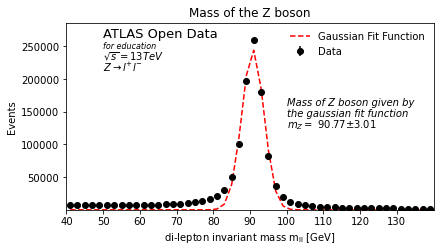

In [14]:
plot_data(sample_data)